In [2]:
import pickle
import torch
from models.timegan import TimeGAN
from models.utils import rescale
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
path="/home/rzhou/Projects/timegan-pytorch/output/inD_18-29_multi_Epoch5000_withoutZfilter_min_G_Loss_period1000epoch"
with open(f"{path}/args.pickle", "rb") as fb:
    args = torch.load(fb)
with open(f"{path}/fake_time.pickle", "rb") as fb:
    fake_time = pickle.load(fb)
print(args)

fake_time = torch.tensor(fake_time, dtype=torch.float32)
print(fake_time)
print(len(fake_time)) 

Namespace(device='cuda', exp='inD_18-29_multi_Epoch5000_withoutZfilter_min_G_Loss_period1000epoch', is_train=True, seed=42, feat_pred_no=1, max_seq_len=100, train_rate=0.5, scaling_method='minmax', emb_epochs=5000, sup_epochs=5000, gan_epochs=5000, batch_size=128, hidden_dim=20, num_layers=3, dis_thresh=0.15, optimizer='adam', learning_rate=0.001, model_path='/home/rzhou/Projects/timegan-pytorch/output/inD_18-29_multi_Epoch5000_withoutZfilter_min_G_Loss_period1000epoch', padding_value=-10.0, feature_dim=10, Z_dim=10)
tensor([100., 100., 100.,  ..., 100., 100., 100.])
1429


In [9]:
from data.data_preprocess import data_preprocess
#data_path="/DATA1/rzhou/ika/multi_testcases/inD_multi_full.csv"
data_path="/DATA1/rzhou/ika/multi_testcases/inD_multi_18-29.csv"

X, T, params_rescale, args.max_seq_len, args.padding_value = data_preprocess(
    file_name=data_path, max_seq_len=args.max_seq_len,scaling_method=args.scaling_method
)

Loading data...



100%|██████████| 2858/2858 [00:04<00:00, 695.88it/s]


In [34]:

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeGAN(args)
model_path = "/home/rzhou/Projects/timegan-pytorch/output/inD_18-29_multi_Epoch5000_withoutZfilter_min_G_Loss_period1000epoch/min_G_loss_model_epoch_4000.pt"
model.load_state_dict(torch.load(model_path))
model.to(args.device)
model.eval()
with torch.no_grad():
    # Generate fake data
    Z = torch.rand((len(fake_time), args.max_seq_len, args.Z_dim))
    generated_data = model(X=None, T=fake_time, Z=Z, obj="inference").numpy()

In [35]:
print(generated_data[0][:,5])

[0.6949697  0.6967647  0.58606654 0.5033212  0.41510338 0.49010855
 0.40347332 0.4642588  0.40494823 0.4564132  0.40533412 0.44971085
 0.40875494 0.44529766 0.41526514 0.4446655  0.4213813  0.4467309
 0.42846495 0.4494583  0.43818456 0.45450586 0.44693828 0.45800304
 0.4535892  0.46125644 0.46051425 0.46648413 0.46723288 0.47189897
 0.47203606 0.4760803  0.47823638 0.48095018 0.48400068 0.48553377
 0.48793954 0.48757905 0.4902808  0.49054348 0.49349082 0.49579984
 0.49375123 0.4997506  0.4968955  0.50274175 0.50148094 0.5039641
 0.5052683  0.50728434 0.50575435 0.50832117 0.50960666 0.51154584
 0.5130178  0.5151225  0.51526517 0.51621217 0.5177189  0.5176806
 0.51648796 0.51919574 0.5172184  0.52062136 0.5208251  0.5215067
 0.5240416  0.5237094  0.5238677  0.52823144 0.52594596 0.52942777
 0.5295945  0.5284475  0.528333   0.52923113 0.53061783 0.5313396
 0.53167367 0.53260726 0.5315436  0.5351578  0.53364956 0.53587836
 0.5348266  0.5363246  0.53523946 0.535712   0.53816295 0.5354783
 

In [36]:
rescaled_generated_data=rescale(generated_data,args.scaling_method,params_rescale)
print(rescaled_generated_data[0][:,1])

[-32.02162   -34.71408   -36.7333    -32.24519   -31.275192  -25.619608
 -30.121534  -23.922867  -28.335978  -22.812222  -26.21982   -21.662382
 -24.3294    -20.654251  -22.707605  -19.780613  -21.275925  -18.975319
 -20.05525   -18.243214  -18.965466  -17.561386  -17.95224   -16.873375
 -17.073101  -16.28587   -16.3452    -15.74543   -15.678886  -15.212017
 -15.08424   -14.730122  -14.619595  -14.322712  -14.163757  -13.922276
 -13.771183  -13.574062  -13.456219  -13.336052  -13.229225  -13.124256
 -12.948978  -12.900688  -12.83728   -12.742397  -12.667358  -12.557392
 -12.5415    -12.490124  -12.388721  -12.351814  -12.386024  -12.346882
 -12.282791  -12.245796  -12.21627   -12.181183  -12.187813  -12.166328
 -12.117443  -12.165916  -12.175087  -12.184288  -12.202641  -12.166576
 -12.19619   -12.191711  -12.157803  -12.231461  -12.210815  -12.187569
 -12.220196  -12.180931  -12.182404  -12.252079  -12.309727  -12.299995
 -12.277805  -12.304245  -12.320633  -12.377895  -12.377708  -12

310


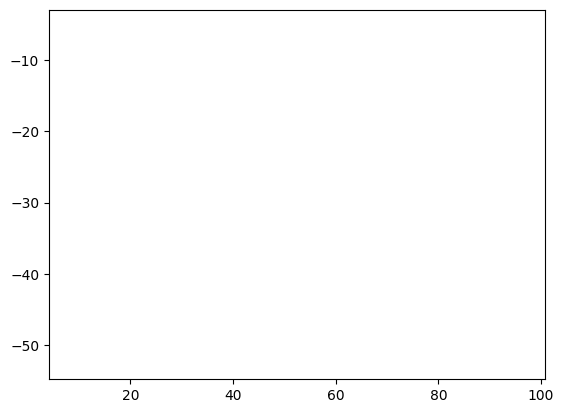

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 假定rescaled_generated_data为(1773, 100, 10)的NumPy数组

# 选择一个随机案例
case_index = np.random.randint(0, rescaled_generated_data.shape[0])
print(case_index)
case_data = rescaled_generated_data[case_index]

frames_per_second = 25
total_seconds_per_case = 4
frames_per_case = frames_per_second * total_seconds_per_case

fig, ax = plt.subplots()
x_min, x_max = np.min(rescaled_generated_data[..., ::2]), np.max(rescaled_generated_data[..., ::2])
y_min, y_max = np.min(rescaled_generated_data[..., 1::2]), np.max(rescaled_generated_data[..., 1::2])
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

points = [ax.plot([], [], 'o', label=f'Point {i+1}')[0] for i in range(5)]

def init():
    for point in points:
        point.set_data([], [])
    return points

def update(frame):
    for i, point in enumerate(points):
        x = case_data[frame, i*2]
        y = case_data[frame, i*2 + 1]
        point.set_data(x, y)
    return points

ani = animation.FuncAnimation(fig, update, frames=frames_per_case, init_func=init, blit=True, repeat=True)

plt.show()

# 注意：由于当前环境限制，实际保存动画需在你的本地环境执行
ani.save('trajectory_animation.mp4', fps=frames_per_second, extra_args=['-vcodec', 'libx264'])
